# Определение возраста покупателей

Добро пожаловать в мой проект!

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных.-Размер-датасета." data-toc-modified-id="Загрузка-данных.-Размер-датасета.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загрузка данных. Размер датасета.</a></span></li><li><span><a href="#Целевой-признак.-Распределение." data-toc-modified-id="Целевой-признак.-Распределение.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Целевой признак. Распределение.</a></span></li><li><span><a href="#Обзор-выборки-из-датасета." data-toc-modified-id="Обзор-выборки-из-датасета.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обзор выборки из датасета.</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Разбор-кода-обучения-модели-на-GPU-тренажёре." data-toc-modified-id="Разбор-кода-обучения-модели-на-GPU-тренажёре.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разбор кода обучения модели на GPU-тренажёре.</a></span></li><li><span><a href="#Результат-обучения." data-toc-modified-id="Результат-обучения.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Результат обучения.</a></span></li></ul></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

<b>Цель: </b>

Требуется построить модель, которая по фотографии определит приблизительный возраст человека. В моём распоряжении набор фотографий людей с указанием возраста.

<b>Задачи: </b>

1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитайте её качество. Требуемый порог метрики MAE - менее 8.

## Исследовательский анализ данных

In [1]:
# загрузим библиотеки для исследовательского анализа
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt

### Загрузка данных. Размер датасета.

Перво-наперво загрузим генератор изображений на основе нашего датасета. При загрузке применим нормализацию - приведение значений интенсивности пикселей к интервалу от 0 до 1.

In [2]:
# Загружаем датасет в виде генератора, который генерит батч изображений размером 32 штуки за раз.
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Итак, в датасете 7591 фотография, значит батчей по 32 там должно быть 238 (238-й неполный). Убедимся, что это так.

In [3]:
len(train_gen_flow)

238

Отлично, данных достаточно много, но не помешает немного добавить. Скорее всего, применим какую-нибудь небольшую аугментацию при загрузке в GPU. 

### Целевой признак. Распределение.

Не лишним будет взглянуть на распределение значений целевого признака. Для этого вытащим из генератора всю последовательность возрастов из 7591 значения.

In [4]:
ages = pd.DataFrame(train_gen_flow.labels)
ages.columns = ['age']
ages.describe()

age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

Судя по статистической сводке, молодость побеждает. Хороший знак, что медиана почти равна среднему, значит, распределение должно выглядеть более-менее симметрично, и, возможно, нет существенных выбросов. Но тут в любом случае есть пол и потолок в 1 и 100 лет. Посмотрим, как оно выглядит на гистограмме.

In [5]:
fig = px.histogram(ages, x='age', nbins=50)
fig.update_layout(
    title="Распределение возрастов в заданном датасете",
    xaxis_title="Возраст",
    yaxis_title="Количество фотографий в датасете")
fig.show()

Ничего себе, сколько там годовалых младенцев. Также видны "выскочки" на возрастах, кратных 10 (30-40-50-..). Возможно, при сборе некоторых данных кто-то округлял возраст. Так как предполагаетсся подбирать товары для возрастных групп, такое округление не будет являться помехой.

В целом, само распределение похоже на правдивый срез населения. Детских фото довольно много, но есть некоторый провал среди 8-11-летних (их мало фотографируют?). Радует, что есть много подростковых "объектов", это поможет научить машинку отличать совершеннолетних от шалунов.

### Обзор выборки из датасета.

Посмотрим, с чем имеем дело: загрузим 15 фотографий.

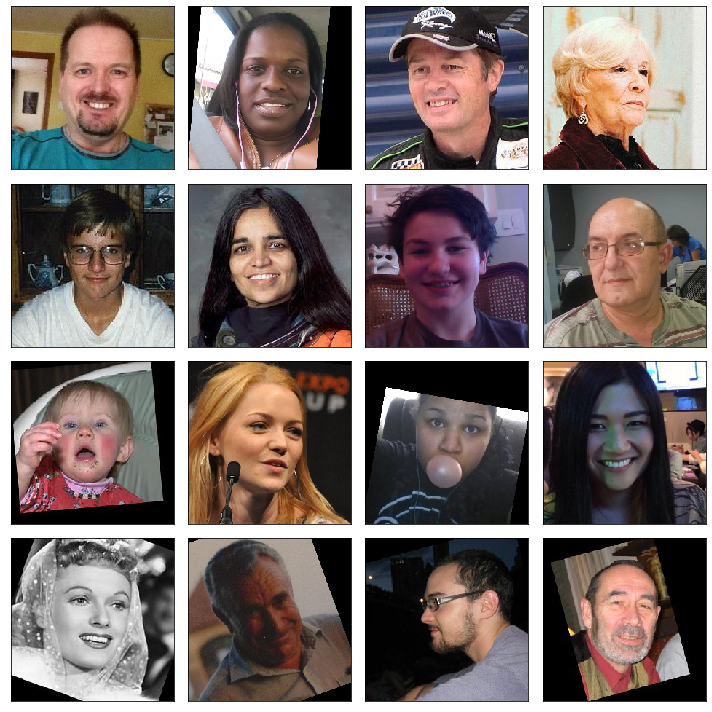

In [6]:
features, target = next(train_gen_flow)
fig2 = plt.figure(figsize=(10,10))
for i in range(16):
    fig2.add_subplot(4,4,i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Есть и ч/б экземпляры, также на фото не всегда нейтральные выражения лиц, это только положительно характеризует датасет, добавит сложности в обучение - следовательно, добавит точности на практике.

Видно также, что пропорции лицо-фон примерно одинаковые, значит, фотографии прошли неплохую стандартизацию перед загрузкой.

Настало время обучить модель по этим замечательным картинкам.

## Обучение модели

Эта часть проекта выполнялась отдельно, после успешного обучения исходный код и вывод GPU после обучения были сохранены и перенесены сюда. 

### Разбор кода обучения модели на GPU-тренажёре.

Что же представляет собой приведённый ниже код.

Для начала в нём представлен раздел загрузки необходимых библиотек, далее сформированы несколько функций.

1. Первые две функции выполняют загрузку данных для обучающей выборки и для тестовой. Как и в исследовательском анализе выше, там применяется нормализация в виде деления на 255 и загрузка батчами рамером в 32 фото. Было решено попробовать добавить данных для обучения путём аугментации, в частности, оказалось достаточным отражение изображений по горизонтали. Аугментация применялась только на обучающей выборке.

2. Следующая функция создаёт, собственно, нашу модель-нейросеть. Она состоит из трёх слоёв:
    - Начинается всё с архитектуры ResNet 50 слоёв с обрезанной "верхушкой"
    - Эту самую верхушку мы замещаем сначала слоем пулинга, возвращающего средние по группе пикселей в канале, и таким образом мы получаем больше каналов на один пиксель
    - И завершает архитектуру полносвязный слой с одним нейроном в конце, так как решается задача регрессии. Функция активации здесь - ReLu (выпрямленное линейное преобразование, приводит к нулю всё, кроме положительных значений, которые оставляет в покое) - она показывает себя лучше прочих в подобных моделях
    - Потом эта же функция настраивает гиперпараметры:
        - мы обращаемся к истокам и призываем Адама, он применит алгоритм, который решит за нас, какие шаги обучения применять в градиентом спуске на разных уровнях нейросети. Единственный пинок, который мы ему дадим - это начальная скорость обучения (шаг спуска). В данном случае удачно применлся довольно скромный шаг в 0.0001.
        - указываем функцию потерь, в нашем случае хорошо подходит привычная для регрессии Mean Squared Error
        - обозначаем метрику качества обучения, ради которой здесь и собрались - Mean Absolute Error
        
3. Завершает код функция обучения созданной выше модели. Единственный параметр, который здесь подбирался - это количество эпох - минимально достаточное количество итераций прохождения через нейросеть. Чтобы сеть не переобучилась и не недообучилась, подошло количество эпох, равное 5.

```python

# код для загрузки в GPU
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
 
 
def load_train(path):
	
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                             rescale=1./255,                        
                             horizontal_flip=True)
				
    train_gen_flow = datagen.flow_from_dataframe(
      dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                             rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
      dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'validation',
        seed=12345)
    return test_gen_flow
 
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=(150, 150, 3),                    
  weights='imagenet',                     
  include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
 
 
    optimizer = Adam(lr=0.0001) 
    model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['mae'])
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:   
        validation_steps=len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 

```

### Результат обучения.

Вот такой результат выдал GPU после применения приведённого выше кода:

```
2021-07-16 23:08:11.151869: .....
.........
Здесь пропущены загрузочные технические строки
.......

Train for 178 steps, validate for 60 steps
Epoch 1/5
2021-07-16 23:08:23.156225: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-16 23:08:23.441937: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 45s - loss: 266.4519 - mae: 11.6354 - val_loss: 963.4466 - val_mae: 26.2815
Epoch 2/5
178/178 - 37s - loss: 79.7079 - mae: 6.7276 - val_loss: 595.7416 - val_mae: 19.0911
Epoch 3/5
178/178 - 37s - loss: 54.1133 - mae: 5.5630 - val_loss: 275.3539 - val_mae: 12.2555
Epoch 4/5
178/178 - 37s - loss: 35.4556 - mae: 4.5483 - val_loss: 114.6261 - val_mae: 8.0909
Epoch 5/5
178/178 - 37s - loss: 27.5549 - mae: 3.9751 - val_loss: 106.8867 - val_mae: 7.8237
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 106.8867 - mae: 7.8237
Test MAE: 7.8237

```

Видно, что данные успешно распределелились между обучаюущей и тестовой выборками. Видно постепенное улучшение метрики на обеих выборках, где на 5 эпохе она достигла желаемого значения меньше 8 для тестовой выборки.

## Анализ обученной модели

Удалось создать качественную модель нейросети, которая, вероятно, пригодится в распознавании лиц заказчику. Удалось это сделать по следующим причинам:
- Исходя из распределения целевого признака - возраста - данные распределены довольно равномерно, что всегда является хорошим подспорьем для обучения без искажений
- Сам датасет достаточно большой, также к нему добавились аугментированные экземпляры - это позволило предоставить нейросетке большую библиотеку
- Данные хорошо "причёсаны" в отношений пропорций лица и фона, такая стандартизация улучшает качество обучения
- Мы использовали популярную и эффективную архитектуру ResNet, и она не подвела, сработав в комплексе с вручную добавленными пулинговым и полносвязным слоями
- Мы удачно подобрали гиперпараметры и параметры. Модель обучалась довольно быстро при довольно маленьком шаге градиентного спуска
- Автор молодец

Спасибо за внимание и знания!

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы